# IBM Data Science Certificate - Cap Stone Project

## Introduction

Data exploration in the City of New York

Comparison of New York City neighborhoods and Tokyo neighborhoods.

In [144]:
import requests
import numpy as np
import pandas as pd

from sklearn.cluster import KMeans

import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

import folium

### Getting Geo Data
New York City Neighborhood Data can obtained through the Socrata Open Data API. This dataset contains borough, neighborhood name, and the geo coordinates data. Property sale price is obtained from the same data source as a complement to the venue data to be collected from Foursquare

In [4]:
j0 = requests.get(r'https://data.cityofnewyork.us/resource/xyye-rtrs.json').json()

In [261]:
#turn json into df then some cleaning
neigh_NY = pd.io.json.json_normalize(j0)
neigh_NY.head()

,annoangle,annoline1,annoline2,annoline3,borough,name,objectid,stacked,the_geom.coordinates,the_geom.type
0,0.0,Wakefield,,,Bronx,Wakefield,1,1,"[-73.8472005205491, 40.89470517661004]",Point
1,0.0,Co-op,City,,Bronx,Co-op City,2,2,"[-73.82993910812405, 40.87429419303015]",Point
2,0.0,Eastchester,,,Bronx,Eastchester,3,1,"[-73.82780644716419, 40.88755567735082]",Point
3,0.0,Fieldston,,,Bronx,Fieldston,4,1,"[-73.90564259591689, 40.895437426903875]",Point
4,0.0,Riverdale,,,Bronx,Riverdale,5,1,"[-73.91258546108577, 40.89083449389134]",Point


In [13]:
neigh_NY.shape #4 duplicates in neighborhood names in differet boroughs Geez.

(299, 10)

In [15]:
#clean up
neigh_NY = neigh_NY[['borough',
                     'name',
                     'the_geom.coordinates']]
#splitting the_geom.coordinates to columns and get the neigh names to be unique by concat borough and neigh
neigh_NY = pd.concat([neigh_NY.borough.map(str).str.upper() + ' | ' + neigh_NY.name.map(str).str.upper(),
                      pd.DataFrame(neigh_NY['the_geom.coordinates'].values.tolist())], axis=1)
neigh_NY.columns = ['name', 'lon', 'lat']
neigh_NY.head()

,name,lon,lat
0,BRONX | WAKEFIELD,-73.847201,40.894705
1,BRONX | CO-OP CITY,-73.829939,40.874294
2,BRONX | EASTCHESTER,-73.827806,40.887556
3,BRONX | FIELDSTON,-73.905643,40.895437
4,BRONX | RIVERDALE,-73.912585,40.890834


In [16]:
neigh_NY.shape

(299, 3)

In [87]:
#NYC city wide data of annualized properties sales
#Data from the same source and similar format
j1 = requests.get(r'https://data.cityofnewyork.us/resource/w2pb-icbu.json?$limit=90000').json()

In [262]:
#now to clean up the property sales dataset
#remove max row
#turn json into df then some cleaning
property_sales_NY = pd.io.json.json_normalize(j1)
property_sales_NY.head()

,address,apartment_number,bbl,bin,block,borough,building_class_as_of_final,building_class_at_time_of,building_class_category,census_tract,...,neighborhood,nta,residential_units,sale_date,sale_price,tax_class_as_of_final_roll,tax_class_at_time_of_sale,total_units,year_built,zip_code
0,738 EAST 6TH STREET,NaN,1003750028,1004440,375,1,C4,C4,07 RENTALS - WALKUP APARTMENTS,2601,...,ALPHABET CITY,Lower East Side,11,2017-04-03T00:00:00.000,3750000,2,2,11,1900,10009
1,27 AVENUE C,NaN,1003850036,1076886,385,1,C7,C7,07 RENTALS - WALKUP APARTMENTS,2202,...,ALPHABET CITY,Lower East Side,24,2017-07-11T00:00:00.000,5235000,2,2,25,1910,10009
2,151 AVENUE B,NaN,1003920005,1004763,392,1,C2,C2,07 RENTALS - WALKUP APARTMENTS,28,...,ALPHABET CITY,Lower East Side,5,2017-06-16T00:00:00.000,0,2A,2,5,1900,10009
3,153 AVENUE B,NaN,1003920006,1004764,392,1,C2,C2,07 RENTALS - WALKUP APARTMENTS,28,...,ALPHABET CITY,Lower East Side,5,2017-07-19T00:00:00.000,6625000,2A,2,5,1900,10009
4,193 EAST 4TH STREET,NaN,1004000061,1005044,400,1,C7,C7,07 RENTALS - WALKUP APARTMENTS,32,...,ALPHABET CITY,East Village,11,2017-11-13T00:00:00.000,7675000,2,2,12,1900,10009


In [267]:
#getting unique class categories
property_sales_NY.building_class_category.unique()

array(['07 RENTALS - WALKUP APARTMENTS',
       '08 RENTALS - ELEVATOR APARTMENTS', '09 COOPS - WALKUP APARTMENTS',
       '10 COOPS - ELEVATOR APARTMENTS', '11A CONDO-RENTALS',
       '12 CONDOS - WALKUP APARTMENTS', '13 CONDOS - ELEVATOR APARTMENTS',
       '44 CONDO PARKING', '14 RENTALS - 4-10 UNIT',
       '15 CONDOS - 2-10 UNIT RESIDENTIAL',
       '16 CONDOS - 2-10 UNIT WITH COMMERCIAL UNIT', '17 CONDO COOPS',
       '37 RELIGIOUS FACILITIES',
       '42 CONDO CULTURAL/MEDICAL/EDUCATIONAL/ETC',
       '46 CONDO STORE BUILDINGS', '47 CONDO NON-BUSINESS STORAGE',
       '01 ONE FAMILY DWELLINGS', '02 TWO FAMILY DWELLINGS',
       '03 THREE FAMILY DWELLINGS', '04 TAX CLASS 1 CONDOS',
       '43 CONDO OFFICE BUILDINGS', '05 TAX CLASS 1 VACANT LAND',
       '21 OFFICE BUILDINGS', '22 STORE BUILDINGS', '23 LOFT BUILDINGS',
       '26 OTHER HOTELS', '28 COMMERCIAL CONDOS', '29 COMMERCIAL GARAGES',
       '30 WAREHOUSES', '34 THEATRES',
       '35 INDOOR PUBLIC AND CULTURAL FACILITIES',

In [268]:
#limit the types of sales
property_sales_NY = property_sales_NY[property_sales_NY.building_class_category.isin(['07 RENTALS - WALKUP APARTMENTS',
                                                                                      '08 RENTALS - ELEVATOR APARTMENTS',
                                                                                      '09 COOPS - WALKUP APARTMENTS',
                                                                                      '10 COOPS - ELEVATOR APARTMENTS',
                                                                                      '12 CONDOS - WALKUP APARTMENTS', 
                                                                                      '13 CONDOS - ELEVATOR APARTMENTS'])]

In [239]:
property_sales_NY.shape

(34595, 28)

In [269]:
#get borough name
property_sales_NY.borough.replace(to_replace=['1', '2', '3', '4', '5'], 
                                  value=['MANHATTAN', 'BRONX', 'BROOKLYN', 'QUEENS', 'STATEN ISLAND'], inplace=True)
# concat borough and neighborhood name and check shape
property_sales_NY['neigh'] = property_sales_NY.borough + ' | ' + property_sales_NY.neighborhood
#it seems the neighborhood names here have too much detail and do not match up with neigh_NY
property_sales_NY.neigh = property_sales_NY.neigh.str.split('-').str[0]
property_sales_NY.neigh = property_sales_NY.neigh.str.split('/').str[0]
property_sales_NY.neigh = property_sales_NY.neigh.str.split('(').str[0]

property_sales_NY.neigh = property_sales_NY.neigh.str.rstrip()
property_sales_NY.shape

(34595, 29)

In [270]:
#slice the data frame to only useful columns
property_sales_NY = property_sales_NY[['neigh', 'gross_square_feet', 'sale_price']] 
#first remove empty values
property_sales_NY = property_sales_NY[(property_sales_NY.gross_square_feet != '-') & (property_sales_NY.sale_price != '-')]
#then convert str to float
property_sales_NY.sale_price = property_sales_NY.sale_price.astype(float)
property_sales_NY.gross_square_feet = property_sales_NY.gross_square_feet.str.replace(',', '').astype(float)
#then take a look at the resulting dataframe
property_sales_NY.describe()

,gross_square_feet,sale_price
count,4.779000e+03,4.779000e+03
mean,1.606252e+04,2.172193e+06
std,9.763168e+04,7.464092e+06
min,0.000000e+00,0.000000e+00
25%,2.580000e+03,0.000000e+00
50%,4.140000e+03,3.250000e+05
75%,9.183500e+03,1.400000e+06
max,3.750565e+06,1.675000e+08


In [271]:
#gross_square_feet and sale_price both cannot be 0
property_sales_NY = property_sales_NY[(property_sales_NY.gross_square_feet > 100) & (property_sales_NY.sale_price > 1000)]
#calculate price per metric
property_sales_NY['price_per_sqft'] = property_sales_NY.sale_price / property_sales_NY.gross_square_feet
#takes 10% to 90% percentile
property_sales_NY = property_sales_NY[(property_sales_NY.price_per_sqft > property_sales_NY.price_per_sqft.quantile(.05))
                                      & (property_sales_NY.price_per_sqft < property_sales_NY.price_per_sqft.quantile(.95))]
property_sales_NY.price_per_sqft.describe()

count    1699.000000
mean      371.595029
std       249.355538
min        25.641026
25%       189.966762
50%       288.831836
75%       495.941776
max      1193.181818
Name: price_per_sqft, dtype: float64

In [272]:
#groupby
property_sales_NY_gb = property_sales_NY.drop(['sale_price', 'gross_square_feet'], axis=1).groupby('neigh').mean().reset_index()
property_sales_NY_gb.shape

(155, 2)

Text(0.5, 1.0, 'median residential sale price per sqft by borough')

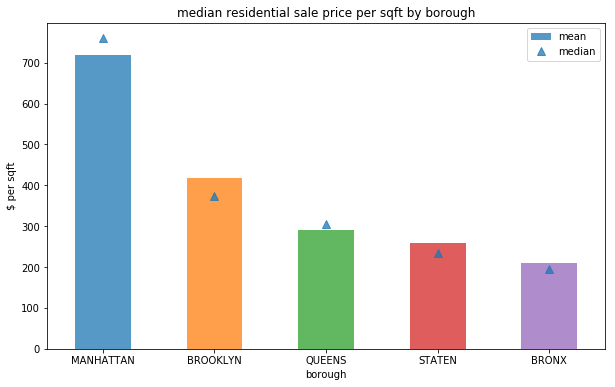

In [368]:
#plot average property price by borough
property_sales_NY_gb['borough'] = property_sales_NY_gb.neigh.str.split(' | ').str[0]
property_sales_NY_gb.drop('neigh', axis=1)

fig, axes = plt.subplots(nrows=1, ncols=1)

property_sales_NY_gbgb = property_sales_NY_gb.groupby('borough').mean().reset_index().sort_values(by='price_per_sqft', ascending=False)
property_sales_NY_gbgb.plot.bar(x='borough', y='price_per_sqft', figsize=(10, 6), alpha=0.75, ax=axes, label='mean')

plt.xlabel('borough')
plt.ylabel('$ per sqft')
plt.title('mean residential sale price per sqft by borough')

property_sales_NY_gbgb = property_sales_NY_gb.groupby('borough').median().reset_index().sort_values(by='price_per_sqft', ascending=False)
property_sales_NY_gbgb.plot(x='borough', y='price_per_sqft', figsize=(10, 6), alpha=0.75, ax=axes, label='median', linestyle='', marker='^', markersize=8)

plt.xlabel('borough')
plt.ylabel('$ per sqft')
plt.title('median residential sale price per sqft by borough')

Text(0.5, 1.0, 'residential sale price per sqft distribution by borough')

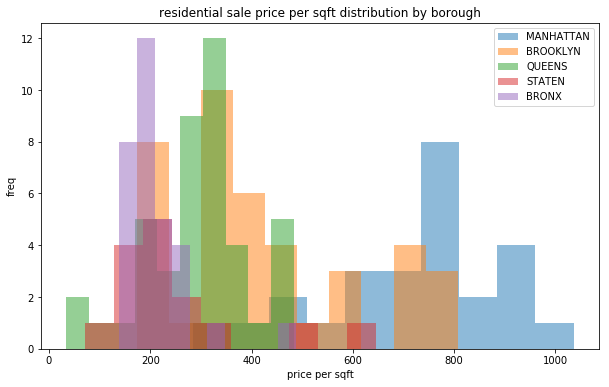

In [370]:
#plot average property price by borough
property_sales_NY_gb['borough'] = property_sales_NY_gb.neigh.str.split(' | ').str[0]

fig, axes = plt.subplots(nrows=1, ncols=1)
boroughs = ['MANHATTAN', 'BROOKLYN', 'QUEENS', 'STATEN', 'BRONX']

for borough in boroughs:
    property_sales_NY_gb[property_sales_NY_gb.borough == borough].plot.hist(x='neigh', y='price_per_sqft', alpha=0.5, figsize=(10, 6), ax=axes, label=borough)

plt.xlabel('price per sqft')
plt.ylabel('freq')
plt.title('residential sale price per sqft distribution by borough')

In [244]:
#this limit the analysis to just 239 neighborhoods. 
neigh_NY0 = neigh_NY.merge(property_sales_NY_gb, how='inner', left_on='name', right_on='neigh')#.drop('neigh', axis=1)
neigh_NY0.head()

,name,lon,lat,neigh,price_per_sqft
0,BRONX | WAKEFIELD,-73.847201,40.894705,BRONX | WAKEFIELD,171.241323
1,BRONX | RIVERDALE,-73.912585,40.890834,BRONX | RIVERDALE,486.900859
2,BRONX | KINGSBRIDGE,-73.902818,40.881687,BRONX | KINGSBRIDGE,244.505876
3,BRONX | WOODLAWN,-73.867315,40.898273,BRONX | WOODLAWN,186.797932
4,BRONX | WILLIAMSBRIDGE,-73.857446,40.881039,BRONX | WILLIAMSBRIDGE,196.465443


In [245]:
#Neighborhood names match up horribly even with the adjustment
neigh_NY0.shape

(125, 5)

### Getting Venue Data
Venue Data is obtained through the Foursquare API.

In [372]:
CLIENT_ID = 'C3GGZ4NKI52HJBQXG2AWRTT0RX4UEMXA2HEOLIFUB3GRAYVH'
CLIENT_SECRET = '2YUECPM10GW2SL4WYEWOPLGB2TWXFYAYBGZFL0QCEVQF3WRV'
DEFAULT_VERSION = '20190317'

In [373]:
#func to compile lists of locations by coords
def get_venue_data(names, lats, lons, price_per_sqfts, radius, LIMIT, client_id=CLIENT_ID, client_secret=CLIENT_SECRET, ver=DEFAULT_VERSION):
    vlst = list()
    
    for name, lat, lon, price_per_sqft in zip(names, lats, lons, price_per_sqfts):
        request_phrase = r'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}' \
                         + '&ll={},{}&radius={}&LIMIT={}'
        request_phrase = request_phrase.format(CLIENT_ID,
                                               CLIENT_SECRET,
                                               DEFAULT_VERSION,
                                               lat,
                                               lon,
                                               radius,
                                               LIMIT)
        #request from 4square
        r = requests.get(request_phrase).json()['response']['groups'][0]['items']
        
        #append results from location explore
        vlst.append([[name,
                      lat,
                      lon,
                      price_per_sqft,
                      v['venue']['name'],
                      v['venue']['location']['lat'],
                      v['venue']['location']['lng'],
                      v['venue']['categories'][0]['name']] for v in r])
    #flattne the list
    vlst = [item for location in vlst for item in location]
    #covert to df
    venues = pd.DataFrame(vlst, columns=['neigh_name',
                                         'neigh_lat',
                                         'neigh_lon',
                                         'price_per_sqft',
                                         'name',
                                         'lat',
                                         'lon',
                                         'category'])
    return venues

In [374]:
venue_NY = get_venue_data(neigh_NY0.name, neigh_NY0.lat, neigh_NY0.lon, neigh_NY0.price_per_sqft, 500, 100)
venue_NY.head()

,neigh_name,neigh_lat,neigh_lon,price_per_sqft,name,lat,lon,category
0,BRONX | WAKEFIELD,40.894705,-73.847201,171.241323,Lollipops Gelato,40.894123,-73.845892,Dessert Shop
1,BRONX | WAKEFIELD,40.894705,-73.847201,171.241323,Rite Aid,40.896649,-73.844846,Pharmacy
2,BRONX | WAKEFIELD,40.894705,-73.847201,171.241323,Carvel Ice Cream,40.890487,-73.848568,Ice Cream Shop
3,BRONX | WAKEFIELD,40.894705,-73.847201,171.241323,Cooler Runnings Jamaican Restaurant Inc,40.898276,-73.850381,Caribbean Restaurant
4,BRONX | WAKEFIELD,40.894705,-73.847201,171.241323,SUBWAY,40.890656,-73.849192,Sandwich Place


In [248]:
venue_NY.shape

(2803, 8)

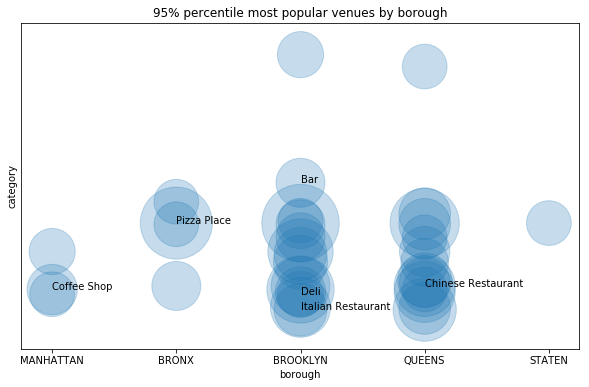

In [566]:
venue_NY['borough'] = venue_NY.neigh_name.str.split(' | ').str[0]
venue_NY_gb = venue_NY.groupby(['borough', 'category'])['name'].count().reset_index()

cate = venue_NY_gb.category.unique()
category_dict = dict(zip(range(len(cate)), cate))

venue_NY_gb.replace(to_replace=cate, value=range(len(cate)), inplace=True)

venue_NY_gb.replace(to_replace=['MANHATTAN', 'BRONX', 'BROOKLYN', 'QUEENS', 'STATEN'],
                                value=[1, 2, 3, 4, 5],
                                inplace=True)

venue_NY_gb.borough = venue_NY_gb.borough.astype(int)
venue_NY_gb.category = venue_NY_gb.category.astype(int) 

for i in range(5):
    venue_NY_gb.name = venue_NY_gb.name / venue_NY_gb[venue_NY_gb.borough == i + 1].name.max()

venue_NY_gb = venue_NY_gb[venue_NY_gb.name > .95]

# venue_NY_gb.name = venue_NY_gb.name / venue_NY_gb.name.max()  

venue_NY_gb.plot.scatter(x='borough', y='category', s=venue_NY_gb.name * 2_000, alpha=0.25, figsize=(10, 6))

x = venue_NY_gb.borough.tolist()
y = venue_NY_gb.category.tolist()

plt.annotate('Coffee Shop', xy=(x[19], y[25]))
plt.annotate('Pizza Place', xy=(x[1], y[2]))
plt.annotate('Italian Restaurant', xy=(x[5], y[5]))
plt.annotate('Bar', xy=(x[5], y[4]))
plt.annotate('Deli', xy=(x[5], y[7]))
plt.annotate('Chinese Restaurant', xy=(x[25], y[10]))

plt.yticks([], [])
plt.ylim([-25, 250])
plt.xticks(range(1, 6), ['MANHATTAN', 'BRONX', 'BROOKLYN', 'QUEENS', 'STATEN'])
plt.title(r'95% percentile most popular venues by borough')

plt.show()

In [563]:
venue_NY_gb['category_'] = venue_NY_gb.category.apply(lambda t: category_dict[t])
venue_NY_gb.sort_values(by='name', ascending=False).reset_index()

,index,borough,category,name,category_
0,254,3,81,3.000000,Pizza Place
1,81,2,81,2.600000,Pizza Place
2,580,4,81,2.400000,Pizza Place
3,150,3,25,2.266667,Coffee Shop
4,210,3,57,2.133333,Italian Restaurant
5,468,4,8,2.000000,Bakery
6,495,4,23,1.866667,Chinese Restaurant
7,506,4,28,1.866667,Deli / Bodega
8,123,3,10,1.800000,Bar
9,157,3,28,1.733333,Deli / Bodega


In [581]:
#target income level for different shops
category_income_lvl = venue_NY.groupby('category')['price_per_sqft'].agg(['mean', 'count']).reset_index()
#to filter out outliers, we require the number of venues city-wide to be greater than 10
category_income_lvl = category_income_lvl[category_income_lvl['count'] > 10] 

category_income_lvl.sort_values(by='mean',  ascending=True).reset_index(drop=True)

,category,mean,count
0,Beach,182.316599,12
1,Discount Store,230.347597,31
2,Bus Stop,235.746397,24
3,Fried Chicken Joint,251.158848,22
4,Donut Shop,253.254593,47
5,Mobile Phone Shop,270.562072,20
6,Breakfast Spot,277.077477,11
7,Supermarket,279.215553,35
8,Bank,282.214516,45
9,Caribbean Restaurant,287.582222,26


### Summarize and Preprocessing Data
Count the number of appearrances of venue categories and preprocess for clustering.

In [249]:
#get onehot then groupby
onehot_NY = pd.concat([venue_NY.neigh_name, venue_NY.price_per_sqft, pd.get_dummies(venue_NY[['category']], prefix='', prefix_sep='')], axis=1)
onehot_NY_gb = onehot_NY.groupby(['neigh_name']).mean().reset_index()
onehot_NY_gb.head()

,neigh_name,price_per_sqft,African Restaurant,Airport Terminal,Airport Tram,American Restaurant,Animal Shelter,Antique Shop,Arcade,Arepa Restaurant,...,Video Store,Vietnamese Restaurant,Warehouse Store,Waste Facility,Waterfront,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,BRONX | BAYCHESTER,173.682705,0.0,0.0,0.0,0.045455,0.0,0.0,0.045455,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,BRONX | BEDFORD PARK,195.181056,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,BRONX | BELMONT,219.297017,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,BRONX | CASTLE HILL,141.947563,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,BRONX | CITY ISLAND,344.961271,0.0,0.0,0.0,0.040000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [250]:
onehot_NY_gb.shape

(125, 298)

### Clustering
Categorize New York Neighborhoods to clusters.
0 for which price data;
1 for no price data

In [251]:
Features_NY0 = onehot_NY_gb.drop(['neigh_name'], axis=1)
Features_NY1 = onehot_NY_gb.drop(['neigh_name', 'price_per_sqft'], axis=1)

In [252]:
#using the mean square error method to find the best k, the minimum group is set to 2 (obviously)

def km_cluster(Features, n_groups, k_small=2, normalize=True):
    clst = list()
    if normalize: 
        Features = StandardScaler().fit_transform(Features)
    
    for k in range(k_small, n_groups + 2):
        cluster = KMeans(n_clusters=k, random_state=0).fit(Features)
        clst.append((k, cluster.inertia_))

    cpd = pd.DataFrame(clst, columns=['k', 'MSE'])
   
    return cpd

In [253]:
km_cluster(Features_NY0, 10, normalize=False).head()

,k,MSE
0,2,1.414103e+06
1,3,6.838089e+05
2,4,3.869328e+05
3,5,2.721814e+05
4,6,2.020670e+05


In [254]:
km_cluster(Features_NY1, 10, normalize=False).head()

,k,MSE
0,2,8.586989
1,3,8.219167
2,4,7.854817
3,5,7.620331
4,6,7.433328


Text(0.5, 1.0, 'MSE vs. k')

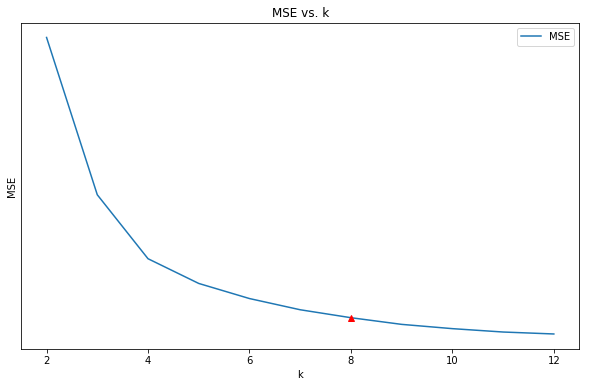

In [597]:
#graph out the MSE
clt = km_cluster(Features_NY0, 11, normalize=False)
clt.plot(x='k', y='MSE')

#looks like the graph flattens at k=8


plt.plot(clt.k[6], clt.MSE[6], color='red', marker='^')
plt.rcParams["figure.figsize"] = (10, 6)

plt.xlabel('k')
plt.yticks([], [])
plt.ylabel('MSE')
plt.title('MSE vs. k')

Text(0.5, 1.0, 'MSE vs. k')

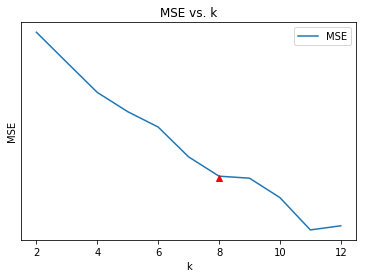

In [583]:
#graph out the MSE
clt = km_cluster(Features_NY1, 11, normalize=False)
clt.plot(x='k', y='MSE')

#looks like the graph flattens at k=9
plt.plot(clt.k[6], clt.MSE[7], color='red', marker='^')

plt.xlabel('k')
plt.ylabel('MSE')
plt.yticks([], [])
plt.title('MSE vs. k')

### Visualize the Results
Instead of checking the standard error I decided to graph every scenario first. Though I had it in my head that k~=5 should be the the magic number.

In [257]:
#define graph function
def cluster_it(k, Features, neigh_name, filename, dir_=r'C:\Users\Anqi Lin\Desktop\IBM_Data_Science_CapStone\Coursera_Capstone'):
    clusters = KMeans(n_clusters=k, random_state=0).fit(Features)

    clusters = pd.concat([neigh_name.reset_index(drop=True), pd.DataFrame(clusters.labels_, columns=['labels_'])], ignore_index=True, axis=1)
    clusters.columns = ['neigh_name', 'labels_']
    
    clusters = neigh_NY.merge(clusters, how='right', left_on='name', right_on='neigh_name').drop(['name'], axis=1)
    clusters = clusters.dropna()

    #visualize in folium
    #borrowing most of these from w2 assignments
    map_cluster = folium.Map(location=[40.7128, -74.0060], zoom_start=11)

    rainbow = [colors.rgb2hex(i) for i in cm.rainbow(np.linspace(0, 1, k))]

    for lat, lon, name, labels_ in zip(clusters.lat, clusters.lon, clusters.neigh_name, clusters.labels_):
        marker = folium.Popup(str(name), parse_html=True)
        folium.CircleMarker([lat, lon],
                            radius=5,
                            popup=marker,
                            color=rainbow[int(labels_ - 1)],
                            fill=True,
                            fill_color=rainbow[int(labels_ -1)]).add_to(map_cluster)

    map_cluster.save(dir_ + r'\\' + filename + r'.html')
    print('complete.')

In [258]:
#run again with optimal k
cluster_it(8, Features_NY0, onehot_NY_gb.neigh_name, 'NY_Cluster_w_Prop_Sales')
cluster_it(9, Features_NY1, onehot_NY_gb.neigh_name, 'NY_Cluster')

complete.
complete.


### A Closer Look at These Observations
!ToDo Update this section by listing popular venues.